不動産価格予測

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Nov 29 08:57:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install optuna xfeat japanize-matplotlib >> /dev/null

In [4]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 
!make -j$(nproc)
!sudo apt-get -y install python-pip

!sudo -H pip install setuptools numpy scipy scikit-learn -U
#pandasのエラーが出る場合は上記のコードからpandasを削除

%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 24227, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 24227 (delta 108), reused 96 (delta 58), pack-reused 24042
Receiving objects: 100% (24227/24227), 19.11 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (17819/17819), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Comp

In [5]:
# パスの設定
My_PATH = "/content/drive/MyDrive/property_values_prediction"

%cd {My_PATH}

/content/drive/MyDrive/property_values_prediction


In [6]:
# zipファイルの解凍

# 古いdata.zipの削除
!rm -r /content/drive/MyDrive/property_values_prediction/data

import zipfile
with zipfile.ZipFile('data.zip', 'r')as f:
    f.extractall('./data')

In [7]:
# train.zipの解凍
# 古いtrain.zipの削除
!rm -r /content/drive/MyDrive/property_values_prediction/data/train

with zipfile.ZipFile('data/train.zip', 'r')as f:
    f.extractall('./data/')

!rm -r /content/drive/MyDrive/property_values_prediction/data/__MACOSX

rm: cannot remove '/content/drive/MyDrive/property_values_prediction/data/train': No such file or directory


In [8]:
import datetime
import os

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")
dir_for_output = "./output/" + current_time

os.makedirs(dir_for_output, exist_ok=True)

In [9]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (
    SelectCategorical,
    LabelEncoder,
    LambdaEncoder,
    Pipeline,
    ConcatCombination,
    SelectNumerical,
    ArithmeticCombinations,
    TargetEncoder,
    aggregation,
    GBDTFeatureSelector,
    GBDTFeatureExplorer,
)

In [10]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

コンペデータ作成（利用カラム、目的変数など決める）

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


In [11]:
BASE_PATH = './data/'
RANDOM_STATE = 10

In [12]:
paths = glob(BASE_PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [13]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              677392
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                660
最寄駅：名称            2672
最寄駅：距離（分）        23098
間取り              23661
面積（㎡）                0
土地の形状           677392
間口              677392
延床面積（㎡）         677392
建築年              19622
建物の構造            16486
用途               58246
今後の利用目的         364049
前面道路：方位         677392
前面道路：種類         677392
前面道路：幅員（ｍ）      677392
都市計画             19221
建ぺい率（％）          23345
容積率（％）           23345
取引時点                 0
改装               61966
取引の事情等          658854
取引価格（総額）_log         0
dtype: int64

In [14]:
sub_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [15]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

In [16]:
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [17]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [18]:
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [19]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [20]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

特徴量生成

In [21]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [22]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836443,
 '京都府': 7.15593584855535,
 '佐賀県': 7.009937258263499,
 '兵庫県': 7.157742870483325,
 '北海道': 6.965967793677889,
 '千葉県': 7.155825324965048,
 '和歌山県': 7.0226902108157585,
 '埼玉県': 7.169744271396765,
 '大分県': 6.911537826573121,
 '大阪府': 7.158352973821433,
 '奈良県': 7.0568846102346985,
 '宮城県': 7.03954425380504,
 '宮崎県': 6.958678653711221,
 '富山県': 7.046920071386999,
 '山口県': 7.045342730349815,
 '山形県': 7.087990602814885,
 '山梨県': 6.848839888686703,
 '岐阜県': 7.078095913486438,
 '岡山県': 7.038090734927505,
 '岩手県': 6.92500267906058,
 '島根県': 7.16537621470031,
 '広島県': 7.09344902165506,
 '徳島県': 6.912051981629739,
 '愛媛県': 6.9664330115966635,
 '愛知県': 7.107301969238665,
 '新潟県': 6.913835156235099,
 '東京都': 7.377929204637786,
 '栃木県': 6.950636958071022,
 '沖縄県': 7.160046604428345,
 '滋賀県': 7.166026958168428,
 '熊本県': 6.970182251843288,
 '石川県': 6.929363348877184,
 '神奈川県': 7.258118267209654,
 '福井県': 6.979575815840192,
 '福岡県': 6.9922649050422665,
 '福島県': 6.974380579140183,
 '秋田県': 6.94131374711262,
 

In [23]:
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,27232131,大阪府,大阪市旭区,新森,森小路,6,１ＬＤＫ,50,昭和49年,ＲＣ,住宅,NaN,準工業地域,80.0,200.0,2005年第３四半期,改装済,NaN,7.041393,0,0.0
1,14289301,神奈川県,川崎市高津区,千年新町,武蔵新城,7,３ＬＤＫ,60,平成4年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2005年第３四半期,改装済,NaN,7.361728,0,0.0


In [24]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [25]:
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,6.0,50,1974.0,80.0,200.0,7.041393,0,0.0,16
1,14289301,7.0,60,1992.0,60.0,200.0,7.361728,0,0.0,16


In [26]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,0,-1


In [27]:
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,100.0
1,120.0


In [28]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,789,808,806,806,8.206591,59.814356,70.397022,236.228288,0.0,15,60.0,200.0,23.0,115,80.0,400.0
1,2945,3089,2872,2872,13.020713,59.043380,61.922006,212.580084,0.0,15,40.0,80.0,105.0,550,80.0,1100.0


In [29]:
feat_df = pd.concat([num_df,le_df,num_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(700543, 38)


In [30]:
feat_df.dtypes

ID                                   int64
最寄駅：距離（分）                          float64
面積（㎡）                                int64
建築年                                float64
建ぺい率（％）                            float64
容積率（％）                             float64
取引価格（総額）_log                       float64
取引時点_enc                             int64
都道府県名_te                           float64
取引時点_何年前                             int64
都道府県名                                int64
市区町村名                                int64
地区名                                  int64
最寄駅：名称                               int64
間取り                                  int64
建物の構造                                int64
用途                                   int64
今後の利用目的                              int64
都市計画                                 int64
改装                                   int64
取引の事情等                               int64
面積（㎡）容積率（％）_combi                  float64
agg_count_最寄駅：距離（分）_grpby_市区町村名      int64
agg_count_面

モデル構築

In [31]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 38) (24899, 38) (23151, 38)


In [32]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [33]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [34]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [39]:
def objective(trial):

    params = {
        "objective": "mean_squared_error",
        "metric": "rmse",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "device": "gpu"
    }

    # LightGBMを利用するのに必要なフォーマットに変換
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)

    # 学習の経過を保存する箱
    evaluation_results = {}

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_names=["train", "valid"],
        valid_sets=[lgb_train, lgb_eval],
        evals_result=evaluation_results,
        early_stopping_rounds=100,
        verbose_eval=500,
    )

    preds = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds)

    return mae

In [40]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(
    direction="minimize", sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50)

[I 2021-11-29 09:13:34,204] A new study created in memory with name: no-name-66ba6823-edf0-4dfe-9f59-228fe335f95b
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.034398 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (13.92 MB) transferred to GPU in 0.026653 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (13.92 MB) transferred to GPU in 0.029593 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:15:42,544] Trial 0 finished with value: 0.07878449569001791 and parameters: {'lambda_l1': 0.08747537025773001, 'lambda_l2': 1.537331564587801e-08, 'num_leaves': 163, 'feature_fraction': 0.8492823295231671, 'bagging_fraction': 0.6991042073815543, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 0 with value: 0.07878449569001791.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035150 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 0.133966	valid's rmse: 0.138088
[1000]	train's rmse: 0.128763	valid's rmse: 0.134202
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.128763	valid's rmse: 0.134202


[I 2021-11-29 09:16:20,139] Trial 1 finished with value: 0.08363986255638278 and parameters: {'lambda_l1': 0.0699481785242808, 'lambda_l2': 3.32657660618516e-07, 'num_leaves': 24, 'feature_fraction': 0.8112158910206784, 'bagging_fraction': 0.972036007716962, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 0 with value: 0.07878449569001791.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036310 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.93 MB) transferred to GPU in 0.033130 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.93 MB) transferred to GPU in 0.037948 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:18:15,101] Trial 2 finished with value: 0.07759068958891356 and parameters: {'lambda_l1': 0.20586790968905005, 'lambda_l2': 0.003256376421394008, 'num_leaves': 186, 'feature_fraction': 0.5751256409023799, 'bagging_fraction': 0.9506644735077661, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.045638 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (13.15 MB) transferred to GPU in 0.026039 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (13.15 MB) transferred to GPU in 0.026169 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:20:10,864] Trial 3 finished with value: 0.07837437768446998 and parameters: {'lambda_l1': 1.9034015928564192e-07, 'lambda_l2': 2.2912202578440842e-05, 'num_leaves': 173, 'feature_fraction': 0.6650999046537976, 'bagging_fraction': 0.6604083959999762, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of 

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.046383 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.82 MB) transferred to GPU in 0.036398 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.82 MB) transferred to GPU in 0.034025 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:22:08,215] Trial 4 finished with value: 0.07900472284141365 and parameters: {'lambda_l1': 0.007137968669448066, 'lambda_l2': 0.0025665550309028774, 'num_leaves': 207, 'feature_fraction': 0.7129882914361805, 'bagging_fraction': 0.945189328485201, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035894 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.45 MB) transferred to GPU in 0.030440 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.45 MB) transferred to GPU in 0.028909 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:24:21,053] Trial 5 finished with value: 0.07776830242671857 and parameters: {'lambda_l1': 5.085111847677709e-06, 'lambda_l2': 1.0613515458050516e-07, 'num_leaves': 213, 'feature_fraction': 0.42813779163354987, 'bagging_fraction': 0.7757722889868355, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of 

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.045509 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (11.51 MB) transferred to GPU in 0.022225 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (11.50 MB) transferred to GPU in 0.021217 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:25:43,576] Trial 6 finished with value: 0.0803390810845248 and parameters: {'lambda_l1': 6.173448891970491e-07, 'lambda_l2': 0.5148168134404182, 'num_leaves': 91, 'feature_fraction': 0.8527886149179144, 'bagging_fraction': 0.5775770241278072, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGB

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.037479 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (9.75 MB) transferred to GPU in 0.018390 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (9.77 MB) transferred to GPU in 0.019126 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry:

[I 2021-11-29 09:26:48,398] Trial 7 finished with value: 0.08391380259135202 and parameters: {'lambda_l1': 3.055927730910031e-07, 'lambda_l2': 3.4100692264414245e-05, 'num_leaves': 25, 'feature_fraction': 0.892663394702157, 'bagging_fraction': 0.4906912117855383, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.049858 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.10 MB) transferred to GPU in 0.029520 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.11 MB) transferred to GPU in 0.027185 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:29:30,526] Trial 8 finished with value: 0.07847073042647619 and parameters: {'lambda_l1': 7.738009776978926, 'lambda_l2': 0.00012786183233975197, 'num_leaves': 212, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.040346 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (11.62 MB) transferred to GPU in 0.020845 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (11.62 MB) transferred to GPU in 0.020622 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:31:10,536] Trial 9 finished with value: 0.07981069830195865 and parameters: {'lambda_l1': 0.0020502757114657026, 'lambda_l2': 2.2570225857344917e-08, 'num_leaves': 93, 'feature_fraction': 0.44776785409357855, 'bagging_fraction': 0.583275951005691, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 2 with value: 0.07759068958891356.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.032672 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.36 MB) transferred to GPU in 0.030344 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.36 MB) transferred to GPU in 0.031669 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:33:49,747] Trial 10 finished with value: 0.07733395754501755 and parameters: {'lambda_l1': 2.868552689905226, 'lambda_l2': 6.220571289776148, 'num_leaves': 251, 'feature_fraction': 0.5856758760408701, 'bagging_fraction': 0.8718151830203783, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 10 with value: 0.07733395754501755.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.034559 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.52 MB) transferred to GPU in 0.028942 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.53 MB) transferred to GPU in 0.028404 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:36:34,637] Trial 11 finished with value: 0.07711937358841507 and parameters: {'lambda_l1': 2.8231671799515703, 'lambda_l2': 7.114706206078692, 'num_leaves': 251, 'feature_fraction': 0.5685849429567916, 'bagging_fraction': 0.8300284786165766, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGB

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035669 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.49 MB) transferred to GPU in 0.029887 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.49 MB) transferred to GPU in 0.030203 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:39:42,245] Trial 12 finished with value: 0.0784105030041306 and parameters: {'lambda_l1': 9.848262935523204, 'lambda_l2': 7.090216318632447, 'num_leaves': 256, 'feature_fraction': 0.5666898450966212, 'bagging_fraction': 0.8282055225313245, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM.

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.034328 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.97 MB) transferred to GPU in 0.030180 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.97 MB) transferred to GPU in 0.029113 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:41:55,721] Trial 13 finished with value: 0.07757529411244372 and parameters: {'lambda_l1': 2.3600253261568453e-05, 'lambda_l2': 0.23503048965961335, 'num_leaves': 247, 'feature_fraction': 0.6873554210426135, 'bagging_fraction': 0.8522869997496058, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of L

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.044720 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.33 MB) transferred to GPU in 0.032770 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.33 MB) transferred to GPU in 0.030176 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:44:21,421] Trial 14 finished with value: 0.07746783658101293 and parameters: {'lambda_l1': 0.7300488068976353, 'lambda_l2': 4.597626052035523, 'num_leaves': 252, 'feature_fraction': 0.9949145705632823, 'bagging_fraction': 0.8704002071004463, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightG

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036188 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.80 MB) transferred to GPU in 0.031307 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.80 MB) transferred to GPU in 0.032243 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:46:09,496] Trial 15 finished with value: 0.0779866032377174 and parameters: {'lambda_l1': 0.00022748874200149782, 'lambda_l2': 0.05437901759511835, 'num_leaves': 136, 'feature_fraction': 0.501393054881619, 'bagging_fraction': 0.8939922815197714, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036528 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.44 MB) transferred to GPU in 0.027598 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.45 MB) transferred to GPU in 0.027418 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:48:26,543] Trial 16 finished with value: 0.07750331378683524 and parameters: {'lambda_l1': 1.7400640800894418, 'lambda_l2': 0.025937842361407493, 'num_leaves': 223, 'feature_fraction': 0.6269119538799264, 'bagging_fraction': 0.7756632816736561, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.049057 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.88 MB) transferred to GPU in 0.035253 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.88 MB) transferred to GPU in 0.037323 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:50:18,491] Trial 17 finished with value: 0.0782195744401721 and parameters: {'lambda_l1': 0.012340753529418833, 'lambda_l2': 0.9405289281613167, 'num_leaves': 130, 'feature_fraction': 0.7281728243847296, 'bagging_fraction': 0.9983144839086054, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.037771 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (12.93 MB) transferred to GPU in 0.025096 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (12.93 MB) transferred to GPU in 0.023070 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:51:44,400] Trial 18 finished with value: 0.07951607129885838 and parameters: {'lambda_l1': 0.0004953784341355079, 'lambda_l2': 7.836542877522026, 'num_leaves': 92, 'feature_fraction': 0.5013601227618107, 'bagging_fraction': 0.6491052389226886, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036191 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (8.74 MB) transferred to GPU in 0.017105 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (8.74 MB) transferred to GPU in 0.018485 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry:

[I 2021-11-29 09:54:15,242] Trial 19 finished with value: 0.07895997158482265 and parameters: {'lambda_l1': 0.8504814347090212, 'lambda_l2': 0.007193506960305306, 'num_leaves': 230, 'feature_fraction': 0.6234953752481641, 'bagging_fraction': 0.43912713666740794, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.051616 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.25 MB) transferred to GPU in 0.032892 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.26 MB) transferred to GPU in 0.030566 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:56:17,759] Trial 20 finished with value: 0.07767626251779046 and parameters: {'lambda_l1': 0.01717525616247439, 'lambda_l2': 1.560311561727413e-06, 'num_leaves': 190, 'feature_fraction': 0.7495316199275592, 'bagging_fraction': 0.8162453473121745, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036926 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.86 MB) transferred to GPU in 0.030481 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.85 MB) transferred to GPU in 0.034732 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 09:58:37,988] Trial 21 finished with value: 0.07744885475080578 and parameters: {'lambda_l1': 1.3307568838203248e-08, 'lambda_l2': 2.0421072971203573, 'num_leaves': 251, 'feature_fraction': 0.7780743752682432, 'bagging_fraction': 0.8966896489336849, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of L

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.034857 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.10 MB) transferred to GPU in 0.035082 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.09 MB) transferred to GPU in 0.032881 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:00:51,042] Trial 22 finished with value: 0.07720187499967916 and parameters: {'lambda_l1': 2.4212931324497212e-05, 'lambda_l2': 0.8517196872207123, 'num_leaves': 233, 'feature_fraction': 0.7614042642151634, 'bagging_fraction': 0.9087751990959906, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.038477 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.20 MB) transferred to GPU in 0.032188 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.20 MB) transferred to GPU in 0.033555 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:03:00,471] Trial 23 finished with value: 0.07751415497595615 and parameters: {'lambda_l1': 2.6286766232797943e-05, 'lambda_l2': 0.111483671565817, 'num_leaves': 233, 'feature_fraction': 0.6217440964412776, 'bagging_fraction': 0.9139814012216538, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.051682 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.10 MB) transferred to GPU in 0.030066 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.10 MB) transferred to GPU in 0.028230 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:05:04,938] Trial 24 finished with value: 0.077661644924239 and parameters: {'lambda_l1': 5.2663092421893456e-05, 'lambda_l2': 0.9547588063576743, 'num_leaves': 199, 'feature_fraction': 0.5087790901503908, 'bagging_fraction': 0.8086207304028852, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035084 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (14.23 MB) transferred to GPU in 0.025931 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (14.23 MB) transferred to GPU in 0.025736 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:06:57,234] Trial 25 finished with value: 0.07869244738220064 and parameters: {'lambda_l1': 2.6511951541560287e-06, 'lambda_l2': 0.22269760755728701, 'num_leaves': 161, 'feature_fraction': 0.6491204713968084, 'bagging_fraction': 0.7147958728509878, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of L

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035555 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.19 MB) transferred to GPU in 0.030932 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.19 MB) transferred to GPU in 0.032624 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:08:57,941] Trial 26 finished with value: 0.07760461461785614 and parameters: {'lambda_l1': 0.000541372813796194, 'lambda_l2': 0.020255668913698937, 'num_leaves': 230, 'feature_fraction': 0.5860768158196304, 'bagging_fraction': 0.8633498496432537, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036454 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.05 MB) transferred to GPU in 0.032225 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.05 MB) transferred to GPU in 0.038392 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:10:19,628] Trial 27 finished with value: 0.08008419493158803 and parameters: {'lambda_l1': 1.909870999622104, 'lambda_l2': 0.0006208484026568532, 'num_leaves': 54, 'feature_fraction': 0.9398382227810946, 'bagging_fraction': 0.9063308019918265, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.047615 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (14.69 MB) transferred to GPU in 0.028741 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (14.69 MB) transferred to GPU in 0.028055 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:12:38,973] Trial 28 finished with value: 0.077758662294341 and parameters: {'lambda_l1': 0.0024741632869854703, 'lambda_l2': 9.61248593180815, 'num_leaves': 235, 'feature_fraction': 0.46395235529407064, 'bagging_fraction': 0.7373859245798482, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightG

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036386 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (13.58 MB) transferred to GPU in 0.026028 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (13.58 MB) transferred to GPU in 0.024824 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:14:31,938] Trial 29 finished with value: 0.07853633764079156 and parameters: {'lambda_l1': 0.07381084060876172, 'lambda_l2': 1.5926981660578812, 'num_leaves': 152, 'feature_fraction': 0.40106230929002956, 'bagging_fraction': 0.6820691191183518, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.034812 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 0.115525	valid's rmse: 0.129255
[1000]	train's rmse: 0.105952	valid's rmse: 0.128026
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.105952	valid's rmse: 0.128026


[I 2021-11-29 10:15:53,494] Trial 30 finished with value: 0.07777970436328123 and parameters: {'lambda_l1': 0.34956548547476357, 'lambda_l2': 0.5418713343451851, 'num_leaves': 179, 'feature_fraction': 0.7810413836144295, 'bagging_fraction': 0.8069897439926994, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035282 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.18 MB) transferred to GPU in 0.033484 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.18 MB) transferred to GPU in 0.032740 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:18:17,640] Trial 31 finished with value: 0.07741062313231942 and parameters: {'lambda_l1': 1.4562431155324835e-08, 'lambda_l2': 1.9588252686397718, 'num_leaves': 256, 'feature_fraction': 0.774661524766246, 'bagging_fraction': 0.9131389621551939, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035391 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.97 MB) transferred to GPU in 0.033065 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.97 MB) transferred to GPU in 0.034769 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:20:35,977] Trial 32 finished with value: 0.07742597735531304 and parameters: {'lambda_l1': 1.6256372557333488e-08, 'lambda_l2': 1.7567495891652123, 'num_leaves': 240, 'feature_fraction': 0.8388081147635572, 'bagging_fraction': 0.9527105934925875, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.056040 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.72 MB) transferred to GPU in 0.042293 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.72 MB) transferred to GPU in 0.035676 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:22:45,793] Trial 33 finished with value: 0.07768864825192592 and parameters: {'lambda_l1': 0.037310281812343825, 'lambda_l2': 0.1498536198509404, 'num_leaves': 216, 'feature_fraction': 0.7955049326036466, 'bagging_fraction': 0.9899997872198004, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.035619 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.66 MB) transferred to GPU in 0.032422 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.66 MB) transferred to GPU in 0.032125 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:24:48,962] Trial 34 finished with value: 0.07739084348253682 and parameters: {'lambda_l1': 0.22656002249282356, 'lambda_l2': 3.6217590048157255, 'num_leaves': 197, 'feature_fraction': 0.7397753644798974, 'bagging_fraction': 0.9370136237232658, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.034170 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.16 MB) transferred to GPU in 0.041858 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.15 MB) transferred to GPU in 0.034884 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:27:11,538] Trial 35 finished with value: 0.07751329650072836 and parameters: {'lambda_l1': 3.7540256696717624, 'lambda_l2': 3.345390877742158, 'num_leaves': 199, 'feature_fraction': 0.6690100364428715, 'bagging_fraction': 0.9618620871197401, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGB

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.047422 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.83 MB) transferred to GPU in 0.034419 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.82 MB) transferred to GPU in 0.033726 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:29:09,171] Trial 36 finished with value: 0.07745617784739142 and parameters: {'lambda_l1': 0.08323944009911051, 'lambda_l2': 0.3740278961329876, 'num_leaves': 200, 'feature_fraction': 0.7094320130060534, 'bagging_fraction': 0.9454017306365031, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.044918 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.66 MB) transferred to GPU in 0.029603 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.67 MB) transferred to GPU in 0.033293 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:30:59,165] Trial 37 finished with value: 0.0787841752066884 and parameters: {'lambda_l1': 0.1988608183439857, 'lambda_l2': 2.054849139061193e-06, 'num_leaves': 222, 'feature_fraction': 0.5918229863034329, 'bagging_fraction': 0.8369219131393332, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.034158 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.50 MB) transferred to GPU in 0.035848 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.50 MB) transferred to GPU in 0.049167 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:33:26,332] Trial 38 finished with value: 0.0776667761242229 and parameters: {'lambda_l1': 0.2965768399949762, 'lambda_l2': 0.06193428638328414, 'num_leaves': 169, 'feature_fraction': 0.5353311156900807, 'bagging_fraction': 0.9290824735931789, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightG

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.062084 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.39 MB) transferred to GPU in 0.038653 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.39 MB) transferred to GPU in 0.030071 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:35:43,305] Trial 39 finished with value: 0.07753242892637967 and parameters: {'lambda_l1': 2.301986477864313, 'lambda_l2': 0.0014328997835843748, 'num_leaves': 187, 'feature_fraction': 0.8310909030029159, 'bagging_fraction': 0.8732584915785008, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.053919 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.45 MB) transferred to GPU in 0.028929 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.45 MB) transferred to GPU in 0.028390 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:36:22,303] Trial 40 finished with value: 0.10467535284810504 and parameters: {'lambda_l1': 0.00472367217815228, 'lambda_l2': 0.009930465425438885, 'num_leaves': 3, 'feature_fraction': 0.7363193914551255, 'bagging_fraction': 0.7758702865236236, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Light

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.058988 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.45 MB) transferred to GPU in 0.033907 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.45 MB) transferred to GPU in 0.033949 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:38:30,913] Trial 41 finished with value: 0.07721559174823918 and parameters: {'lambda_l1': 7.173611924475782e-08, 'lambda_l2': 9.937666536132946, 'num_leaves': 240, 'feature_fraction': 0.7594233283205493, 'bagging_fraction': 0.9267900911639149, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036676 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.45 MB) transferred to GPU in 0.035729 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.45 MB) transferred to GPU in 0.039131 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:40:37,921] Trial 42 finished with value: 0.07787838312115387 and parameters: {'lambda_l1': 4.5967157929916045e-08, 'lambda_l2': 9.213623867530796, 'num_leaves': 240, 'feature_fraction': 0.8828183986131208, 'bagging_fraction': 0.9765472758045028, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.041802 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.65 MB) transferred to GPU in 0.033155 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.65 MB) transferred to GPU in 0.032222 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:42:38,443] Trial 43 finished with value: 0.07784495637740249 and parameters: {'lambda_l1': 2.6924078775775587e-06, 'lambda_l2': 3.571123197256383, 'num_leaves': 209, 'feature_fraction': 0.683335074664492, 'bagging_fraction': 0.8865389562848346, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.059102 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.58 MB) transferred to GPU in 0.033371 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.58 MB) transferred to GPU in 0.035001 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:45:00,763] Trial 44 finished with value: 0.07718580648936937 and parameters: {'lambda_l1': 7.138608040039121e-07, 'lambda_l2': 0.873998790180894, 'num_leaves': 244, 'feature_fraction': 0.7514909324153456, 'bagging_fraction': 0.9330704897495461, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.057088 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.07 MB) transferred to GPU in 0.033469 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (17.06 MB) transferred to GPU in 0.032271 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:47:08,217] Trial 45 finished with value: 0.07809894817896426 and parameters: {'lambda_l1': 1.3082923174334606e-07, 'lambda_l2': 0.6598035052871789, 'num_leaves': 242, 'feature_fraction': 0.8131811938010413, 'bagging_fraction': 0.8572838901895995, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.057169 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.72 MB) transferred to GPU in 0.030897 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.72 MB) transferred to GPU in 0.031400 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:49:27,474] Trial 46 finished with value: 0.0778516555856851 and parameters: {'lambda_l1': 1.1245014060863897e-06, 'lambda_l2': 0.4989235993984541, 'num_leaves': 221, 'feature_fraction': 0.8848602969663059, 'bagging_fraction': 0.8398613468083047, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.036764 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.77 MB) transferred to GPU in 0.030229 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (15.78 MB) transferred to GPU in 0.030045 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:52:01,686] Trial 47 finished with value: 0.07756131512177508 and parameters: {'lambda_l1': 9.257605332352516e-08, 'lambda_l2': 0.06550208142030933, 'num_leaves': 245, 'feature_fraction': 0.7042703484568905, 'bagging_fraction': 0.7922357336022708, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.063230 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.38 MB) transferred to GPU in 0.036228 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.38 MB) transferred to GPU in 0.036168 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:54:18,894] Trial 48 finished with value: 0.07747167201542769 and parameters: {'lambda_l1': 6.504140667155585e-07, 'lambda_l2': 1.1929506135695565, 'num_leaves': 256, 'feature_fraction': 0.7606606330003178, 'bagging_fraction': 0.9730344932355988, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 11 with value: 0.07711937358841507.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.059399 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.42 MB) transferred to GPU in 0.036315 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (18.42 MB) transferred to GPU in 0.035341 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

[I 2021-11-29 10:55:50,498] Trial 49 finished with value: 0.07964872914792427 and parameters: {'lambda_l1': 9.818845260223432e-06, 'lambda_l2': 3.3945638826362206e-05, 'num_leaves': 68, 'feature_fraction': 0.6571923650916425, 'bagging_fraction': 0.9251520696718768, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 11 with value: 0.07711937358841507.


CPU times: user 3h 9min 26s, sys: 3min 36s, total: 3h 13min 2s
Wall time: 1h 42min 16s


In [42]:
best_params = study.best_params
best_params["device"] = "gpu"
best_params["random_state"] = RANDOM_STATE
best_params

{'bagging_fraction': 0.8300284786165766,
 'bagging_freq': 6,
 'device': 'gpu',
 'feature_fraction': 0.5685849429567916,
 'lambda_l1': 2.8231671799515703,
 'lambda_l2': 7.114706206078692,
 'min_child_samples': 75,
 'num_leaves': 251,
 'random_state': 10}

In [46]:
# LightGBMを利用するのに必要なフォーマットに変換
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)

evaluation_results = {}

# チューニングしたハイパーパラメーターをフィット
optimised_model = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    valid_names=["train", "valid"],
    evals_result=evaluation_results,
    valid_sets=[lgb_train, lgb_eval],
    early_stopping_rounds=100,
    verbose_eval=500,
    )

val_pred = optimised_model.predict(val_x)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(optimised_model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:176: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:234: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:250: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 36
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (19.91 MB) transferred to GPU in 0.041983 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.219515
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.54 MB) transferred to GPU in 0.031345 secs. 1 sparse feature groups
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.54 MB) transferred to GPU in 0.031893 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entr

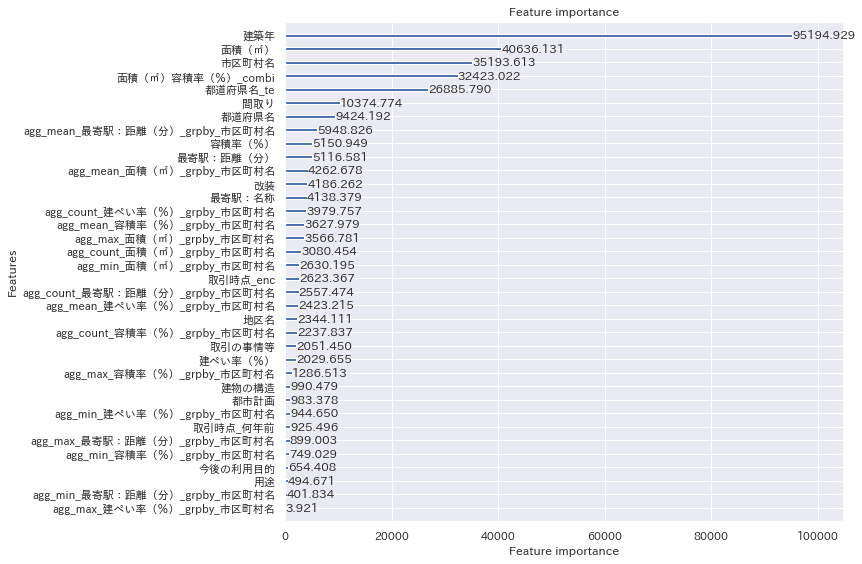

In [47]:
lgb.plot_importance(optimised_model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(dir_for_output + '/feature_importance.png')
plt.show()
plt.close()

In [48]:
# LightGBM推論
y_pred = optimised_model.predict(test_x)

In [49]:
test_df[TARGET] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(dir_for_output + '/test_submission.csv', index=False)

In [51]:
# モデルを保存する
import pickle

file = 'trained_model.pkl'
pickle.dump(optimised_model, open(dir_for_output + "/" + file, 'wb'))